In [1]:
import numpy as np
import scipy.sparse as sp
from graphgallery import functional as gf 
import graphgallery as gg
gg.__version__

'0.8.0'

# Use PyTorch backend

In [2]:
gg.set_backend("torch")

PyTorch 1.6.0 Backend

# Load datasets
+ cora
+ citeseer
+ cora_ml
+ pubmed

In [3]:
dataset = 'cora'
data = gg.datasets.NPZDataset(dataset, root='~/GraphData/datasets/', transform="standardize",  verbose=False)
splits = data.split_nodes(random_state=15)
graph = data.graph

# Load adversarial edges generated by Nettack
To reuse these results and save time, we generate the adversarial edges in advance and store them in a file ends with `.npy`.
Actually, it is a `Dict` instance representing a target node with a few edge flips genetated by [Nettack](https://github.com/danielzuegner/nettack)

In [4]:
attacker_name = 'Nettack'
direct_attack = True
adv_edges = np.load(f'adversarial_edges/targeted/{data.name}_{attacker_name}{"_In" if not direct_attack else ""}.npy', allow_pickle=True).item()
targets = np.array(list(adv_edges.keys()))
print(f"Attack {targets.size} nodes on {data.name}, attacker: {attacker_name}, setting: {'direct attack' if direct_attack else 'indirect attack'}")

Attack 1000 nodes on cora, attacker: Nettack, setting: direct attack


# GCN before attack

In [5]:
gcn = gg.gallery.nodeclas.GCN(device="cuda", seed=10).make_data(graph).build(hids=64)
his = gcn.fit(splits.train_nodes, splits.val_nodes, verbose=1, epochs=200)

# performance on 1000 target nodes
gcn.evaluate(splits.test_nodes)

Training...
200/200 [====================] - Total: 1.82s - 9ms/step - loss: 0.045 - accuracy: 0.992 - val_loss: 0.698 - val_accuracy: 0.807
Testing...
1/1 [====================] - Total: 3.30ms - 3ms/step - loss: 0.618 - accuracy: 0.850


Objects in BunchDict:
╒══════════╤═══════════╕
│ Names    │   Objects │
╞══════════╪═══════════╡
│ loss     │  0.617904 │
├──────────┼───────────┤
│ accuracy │  0.849598 │
╘══════════╧═══════════╛

# Ours before attack

In [6]:
from median_gcn import MedianGCN
from trimmed_gcn import TrimmedGCN

In [7]:
median = MedianGCN(device="cuda", seed=10).make_data(graph).build(hids=64, weight_decay=5e-5)
# median = TrimmedGCN(device="cuda", seed=10).make_data(graph).build(hids=64, weight_decay=5e-5)
his = median.fit(splits.train_nodes, splits.val_nodes, verbose=1, epochs=200)

# performance on test set
median.evaluate(splits.test_nodes)

Training...
200/200 [====================] - Total: 350.77s - 1s/step - loss: 0.025 - accuracy: 0.992 - val_loss: 1.037 - val_accuracy: 0.815
Testing...
1/1 [====================] - Total: 120.44ms - 120ms/step - loss: 0.516 - accuracy: 0.853


Objects in BunchDict:
╒══════════╤═══════════╕
│ Names    │   Objects │
╞══════════╪═══════════╡
│ loss     │  0.515891 │
├──────────┼───────────┤
│ accuracy │  0.852616 │
╘══════════╧═══════════╛

# Attack
Here we choose `target=1` as a toy example

In [8]:
target = 1
target_label = graph.y[target]
num_budgets = int((graph.degree[target] + 1) / 2) + 1
print(f"Attack target node {target} with classes {target_label}. \nThe degree of target node {target} is {graph.degree[target]}, thus we use {num_budgets} as attack budgets")

Attack target node 1 with classes 2. 
The degree of target node 1 is 4.0, thus we use 3 as attack budgets


# GCN under direct attack

In [9]:
# prediction before attack
gcn.make_data(graph)
gcn_predict_before = gcn.predict(target, transform='softmax')

######## Attack ################
gcn.make_data(graph.from_flips(edge_flips=adv_edges[target][:num_budgets]))
# prediction after attack
gcn_predict_after = gcn.predict(target, transform='softmax')

print(f"classification_margin: {gcn_predict_before[target_label]-gcn_predict_after[target_label]}")

classification_margin: 0.4920567274093628


# Ours under direct attack

In [10]:
# prediction before attack
median.make_data(graph)
median_predict_before = median.predict(target, transform='softmax')

######## Attack ################
median.make_data(graph.from_flips(edge_flips=adv_edges[target][:num_budgets]))
# prediction after attack
median_predict_after = median.predict(target, transform='softmax')

print(f"classification_margin: {median_predict_before[target_label]-median_predict_after[target_label]}")

classification_margin: 0.06581759452819824


# Visualization

In [11]:
import matplotlib.pyplot as plt
def make_xlabel(ix, correct):
    if ix == correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)

def visualize(predict_before, predict_after, target, target_label, num_classes):
    if predict_before.ndim == 1:
        predict_before = predict_before.reshape(1, -1)
    if predict_after.ndim == 1:
        predict_after = predict_after.reshape(1, -1)        
        
    figure = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    center_ixs_clean = []
    for ix, block in enumerate(predict_before.T):
        x_ixs = np.arange(len(block)) + ix*(len(block)+2)
        center_ixs_clean.append(np.mean(x_ixs))
        color = '#555555'
        if ix == target_label:
            color = 'darkgreen'
        plt.bar(x_ixs, block, color=color)

    ax = plt.gca()
    plt.ylim((-.05, 1.05))
    plt.ylabel("Predicted probability")
    ax.set_xticks(center_ixs_clean)
    ax.set_xticklabels([make_xlabel(k, target_label) for k in range(num_classes)])
    ax.set_title(f"Predicted class probabilities for node {target} on clean data")

    fig = plt.subplot(1, 2, 2)
    center_ixs_retrain = []
    for ix, block in enumerate(predict_after.T):
        x_ixs = np.arange(len(block)) + ix*(len(block)+2)
        center_ixs_retrain.append(np.mean(x_ixs))
        color = '#555555'
        if ix == target_label:
            color = 'darkgreen'
        plt.bar(x_ixs, block, color=color)


    ax = plt.gca()
    plt.ylim((-.05, 1.05))
    ax.set_xticks(center_ixs_retrain)
    ax.set_xticklabels([make_xlabel(k, target_label) for k in range(num_classes)])
    ax.set_title(f"Predicted class probabilities for node {target} after perturbations")
    plt.tight_layout()
    plt.show()

## GCN

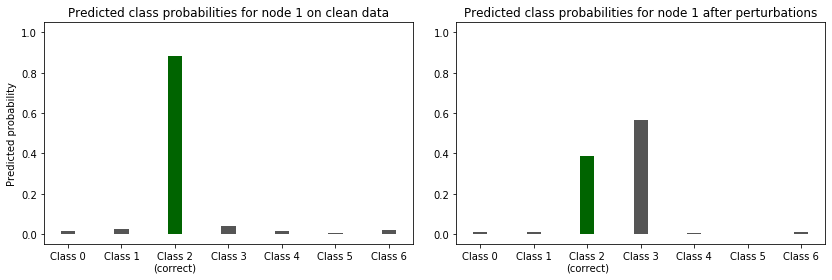

In [12]:
visualize(gcn_predict_before, gcn_predict_after, target, target_label, num_classes=graph.num_classes)

## MedianGCN

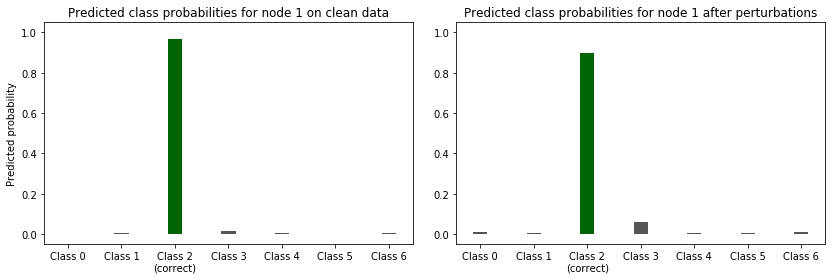

In [13]:
visualize(median_predict_before, median_predict_after, target, graph.y[target], num_classes=graph.num_classes)